In [5]:
import numpy as np
from numba import jit
import pints
import pints.plot
import coag_cst_pro_cst as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [6]:

model = toy.SmolModel(None,None)


true_parameters = [2e-04, 2.5e-03, 600]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


[[6.00000000e+00 3.56400000e+03 9.84937059e+00 9.80101010e+01]
 [5.99655167e+00 3.55541472e+03 9.84936471e+00 9.80100245e+01]
 [5.99310739e+00 3.54685777e+03 9.84934710e+00 9.80097955e+01]
 ...
 [1.00809452e+00 5.50592382e+00 2.86589625e+00 1.06202011e+01]
 [1.00801810e+00 5.50437015e+00 2.86569543e+00 1.06189476e+01]
 [1.00794169e+00 5.50281704e+00 2.86549464e+00 1.06176943e+01]]
(9700, 4)


Add noise to the data (using random sampling from normal distribution)

In [7]:

# noise = 1
# values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
values = org_values


# values = org_values + noise * np.random.normal(0, 0.25, org_values.shape))
# values = np.log(org_values) + noise * np.random.normal(0, 1, org_values.shape)
# values = np.exp(values)

# size_noise = 100
# noise_value = 25
# # Create a list with the specified size filled with a placeholder value
# noise_arr = [noise_value for _ in range(size_noise)]


Set-up pints problem and log likelihoods

In [8]:

problem = pints.MultiOutputProblem(model, times, values)


log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood_2.n_parameters()))

# true_parameters += noise_arr
print(true_parameters)



Original problem dimension: 3
New dimension: 3
[0.0002, 0.0025, 600]


Create uniform log prior

In [9]:

# # Define the size of the list
# size = 102
# placeholder_lower_value = 1
# placeholder_upper_value = 50
 
# # Create a list with the specified size filled with a placeholder value
# prior_arr_lower = [placeholder_lower_value for _ in range(size)]
# prior_arr_upper = [placeholder_upper_value for _ in range(size)]
# prior_arr_lower[0] = 0.0001
# prior_arr_upper[0] = 0.001
# prior_arr_lower[1] = 100
# prior_arr_upper[1] = 1000

log_prior = pints.UniformLogPrior(
    [0.000001, 0.000001, 1],
    [0.01, 0.01, 10000]
    )
# log_prior = pints.UniformLogPrior(
#     prior_arr_lower,
#     prior_arr_upper
#     )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_60261/342184121.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [10]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.2
1     210     0:04.3
2     330     0:06.8
3     405     0:08.2
20    2172    0:38.4
40    4590    1:19.6
60    8547    2:27.3
80    12996   3:42.7
100   18027   5:08.6
120   23724   6:44.2
140   30072   8:30.8
160   36846  10:23.6
180   44346  12:39.3
200   52089  14:54.3
220   60468  17:22.3
240   69672  20:11.0
260   79608  23:06.8
280   92010  26:46.4
300   105288  30:40.1
320   118698  34:35.6
340   131784  38:34.6
360   144744  42:22.4
380   157329  46:03.5
400   170454  49:53.0
420   183525  53:41.0
440   196620  57:32.3
460   209397  61:13.2
480   222705  65:05.4
500   235311  68:44.1
520   248091  72:30.0
540   260976  76:10.9
560   273906  79:56.0
580   286782  83:42.1
600   299532  87:27.3
620   312615  91:20.9
640   325575  95:11.0
660   338475  99:01.2
680   351534 102:54.0
700   364383 106:43.6
720   377172 110:31.2
740   389967 114:17.9
760   402459 1

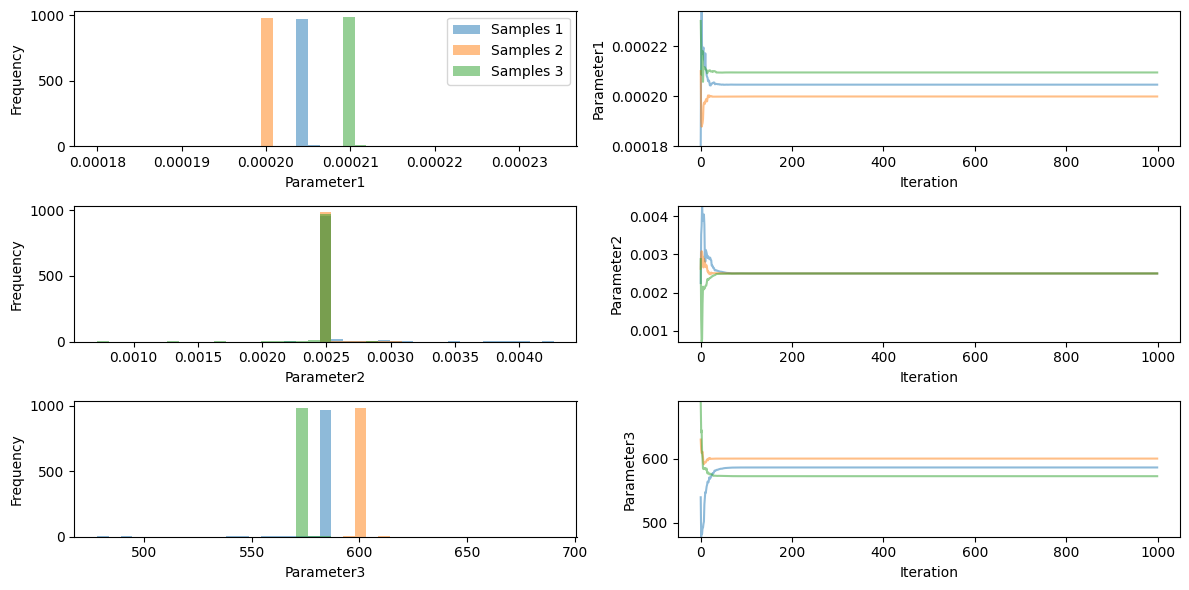

In [11]:

pints.plot.trace(chains)
plt.savefig("mcmc.png")
plt.show()